# Load Model and Evaluation

## Import libraries

In [1]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import numpy as np
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
import os
from PIL import Image
import pathlib
import glob
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, precision_score, recall_score
)
from torchvision.models import resnet18
import seaborn as sns

## Set path to the train, valid, test data

In [ ]:
#Path for train, valid, test directory
train_path = 'content/train'
pred_path = 'content/valid'
test_path = 'content/test'

## Loop all class in directory

In [ ]:
#Categories
root = pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['A', 'AA', 'AAA', 'By', 'black', 'ear', 'fade', 'half', 'hole', 'peaberry', 'triangle', 'uncomplete']


## Load state dict model

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/CoffeeFromResnet/best_checkpoint_resnet18.model')
model = resnet18(num_classes=12)
model.load_state_dict(checkpoint)
model.eval()

<ipython-input-13-2b6eb3b2bb41>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/CoffeeFromResnet/best_checkpoint_resnet18.mo

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Set default of image to tensor

In [ ]:
#Transforms
transformer = transforms.Compose([
    transforms.Resize((256, 256)),            # Resize image to 256x256
    transforms.ToTensor(),                     # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  # Normalize with mean and std
                         std=[0.5, 0.5, 0.5])
])

## Prediction function

In [ ]:
#Prediction function
def prediction(img_path,transformer):

    image = Image.open(img_path)

    image_tensor = transformer(image).float()

    image_tensor = image_tensor.unsqueeze_(0)

    if torch.cuda.is_available():
        image_tensor.cuda()

    input = Variable(image_tensor)

    output = model(input)

    index = output.data.numpy().argmax()

    pred = classes[index]

    return pred
#

In [ ]:
#images_path = glob.glob(pred_path+'/*.jpg')

## Test prediction on test data

In [ ]:
# Dictionary for summary of each classes
prediction_summary = defaultdict(lambda: defaultdict(int))

# Lists of true, pred label for confusion matrix
true_labels = []
pred_labels = []

def process_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.png')):
            img_path = os.path.join(folder_path, filename)

            # Predict
            predicted_class = prediction(img_path, transformer)

            # True class = name of folder of each class
            true_class = os.path.basename(folder_path)

            # Summary update
            prediction_summary[true_class]['total'] += 1
            prediction_summary[true_class][predicted_class] += 1

            # Lists of true, pred label append confusion matrix
            true_labels.append(true_class)
            pred_labels.append(predicted_class)

            # Show each image with true and predict class
   #         img = Image.open(img_path)
   #         plt.imshow(img)
   #         plt.title(f'True: {true_class} | Predicted: {predicted_class}')
   #         plt.show()

In [ ]:
# วนลูปผ่านทุกโฟลเดอร์ใน pred_path
for folder_name in os.listdir(pred_path):
    folder_path = os.path.join(pred_path, folder_name)
    if os.path.isdir(folder_path):
        process_folder(folder_path)

# Predict result
for true_class, predictions in prediction_summary.items():
    print(f'Actual : {true_class}')
    for predicted_class, count in predictions.items():
        if predicted_class != 'total':
            print(f'Predict {predicted_class} : {count}')
    print(f'Total : {predictions["total"]}')
    print('---')



Actual : A
Predict A : 59
Predict peaberry : 1
Total : 60
---
Actual : AA
Predict AA : 55
Predict AAA : 1
Predict ear : 3
Predict A : 1
Total : 60
---
Actual : AAA
Predict AAA : 60
Total : 60
---
Actual : black
Predict black : 59
Predict peaberry : 1
Total : 60
---
Actual : By
Predict By : 59
Predict peaberry : 1
Total : 60
---
Actual : ear
Predict ear : 59
Predict peaberry : 1
Total : 60
---
Actual : fade
Predict ear : 3
Predict fade : 53
Predict AAA : 2
Predict black : 2
Total : 60
---
Actual : half
Predict half : 58
Predict triangle : 1
Predict ear : 1
Total : 60
---
Actual : hole
Predict hole : 56
Predict uncomplete : 2
Predict half : 1
Predict triangle : 1
Total : 60
---
Actual : peaberry
Predict peaberry : 59
Predict By : 1
Total : 60
---
Actual : triangle
Predict triangle : 57
Predict ear : 1
Predict half : 1
Predict uncomplete : 1
Total : 60
---
Actual : uncomplete
Predict uncomplete : 60
Total : 60
---


## Graph for evaluation model

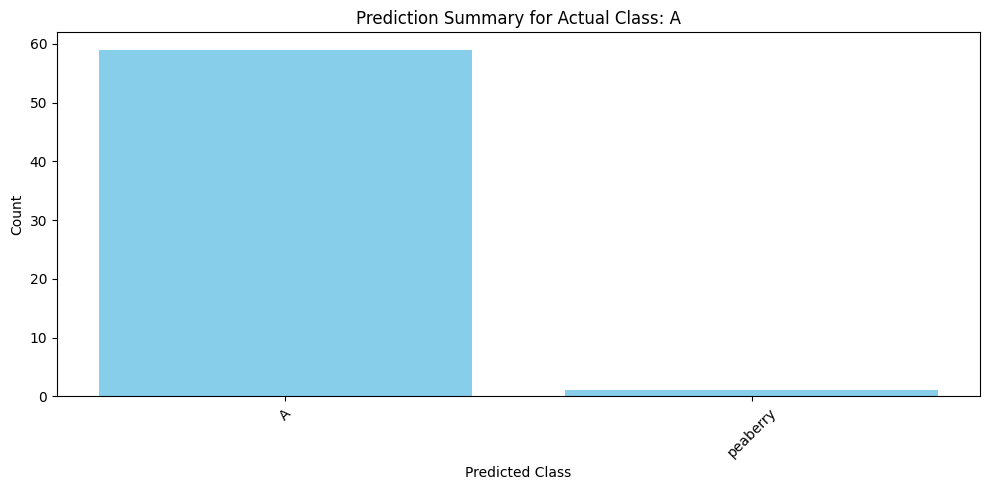

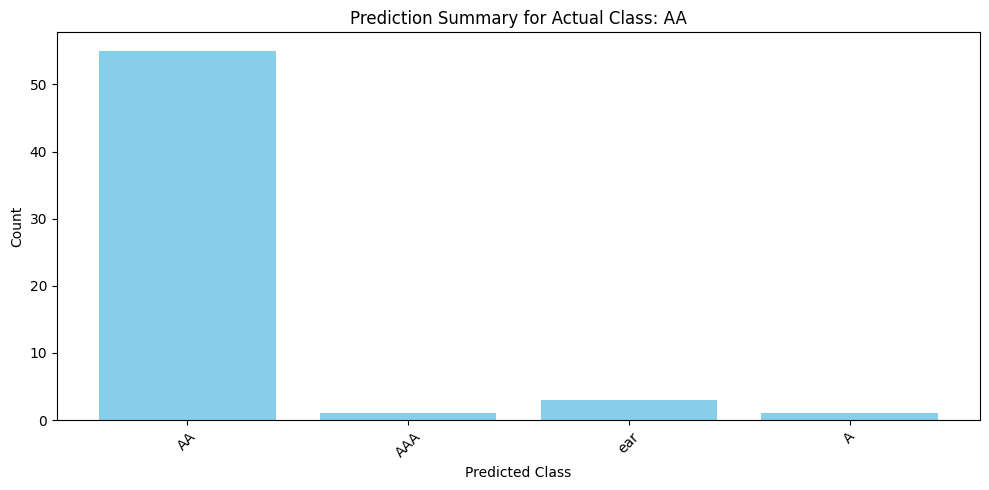

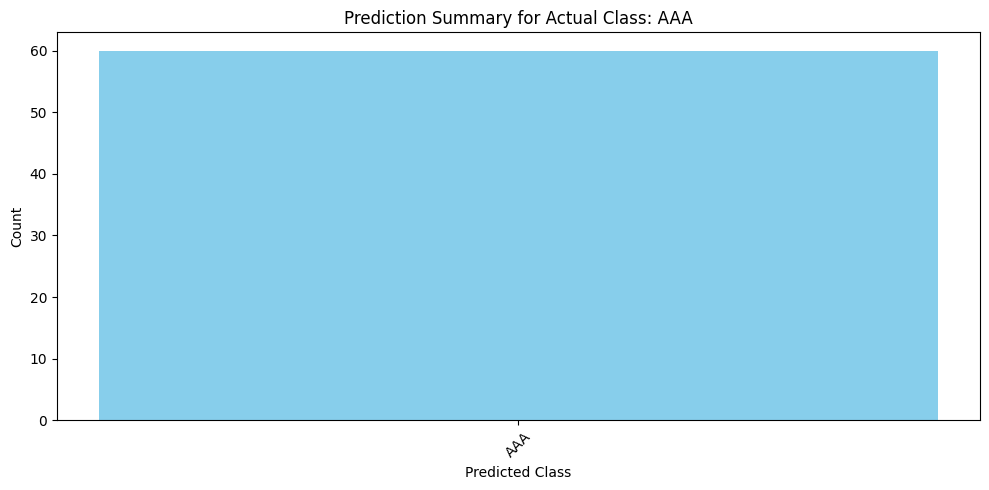

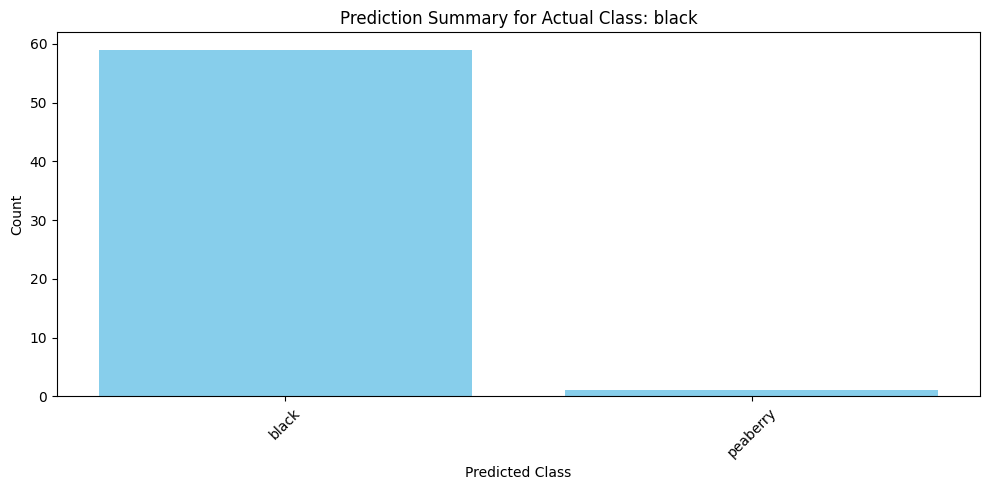

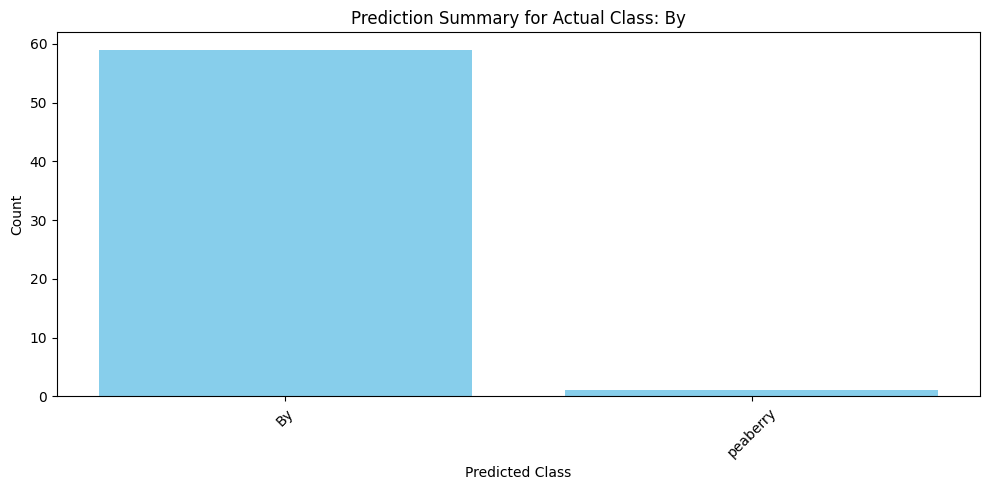

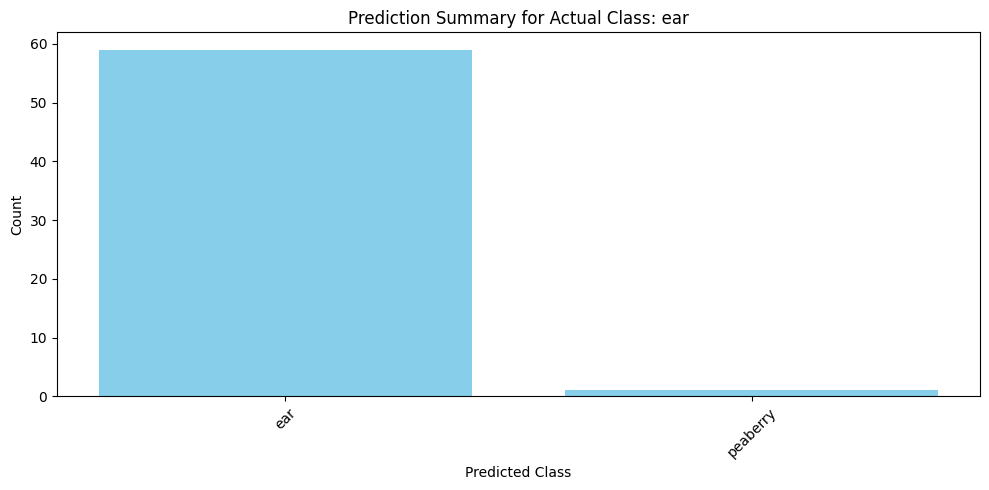

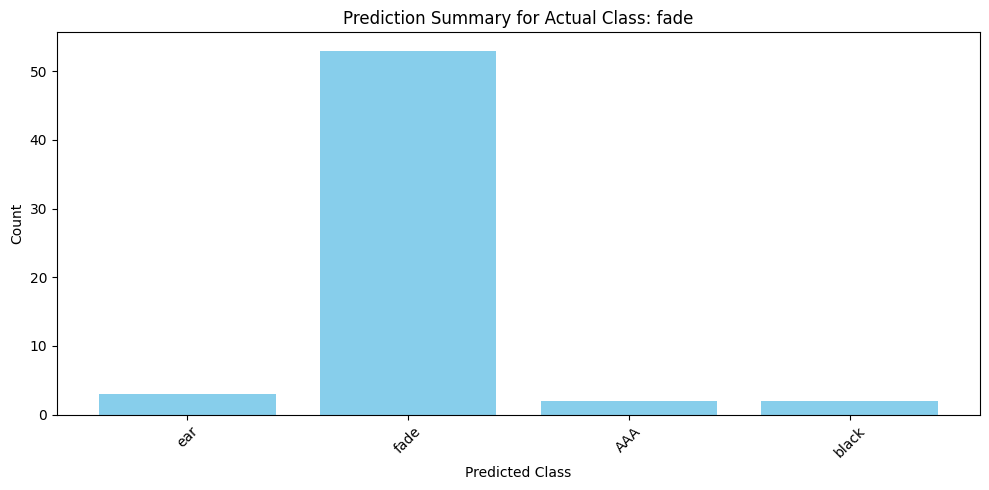

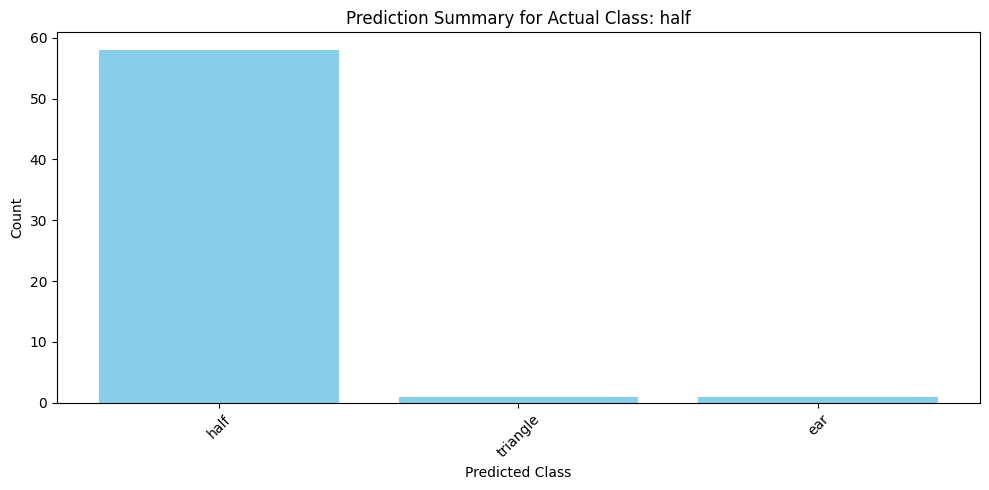

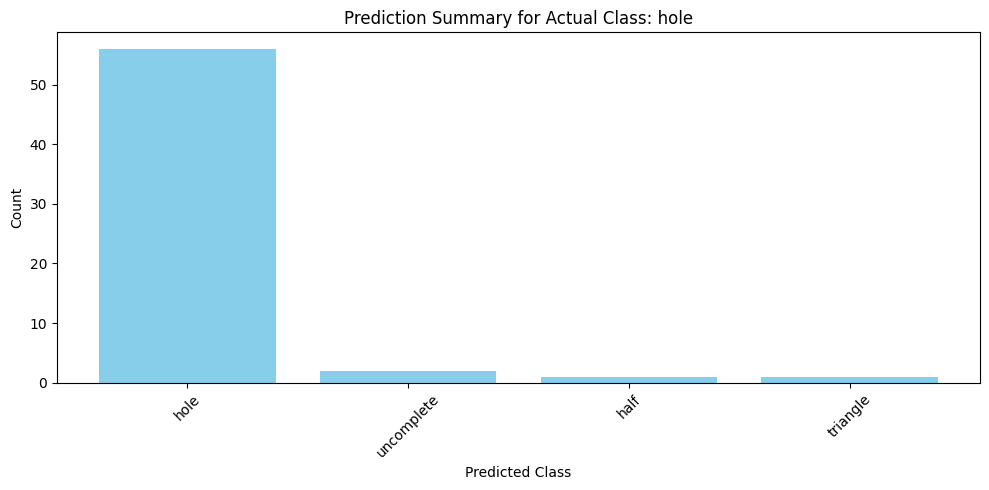

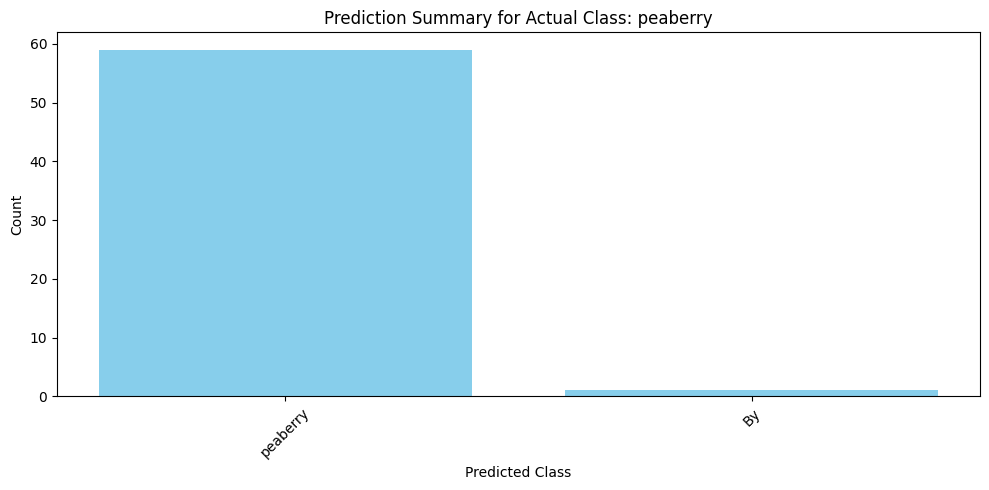

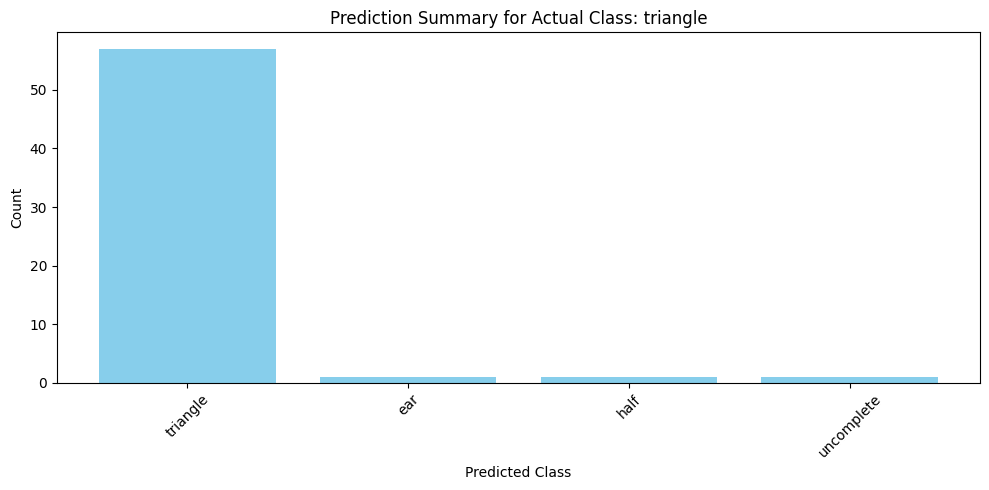

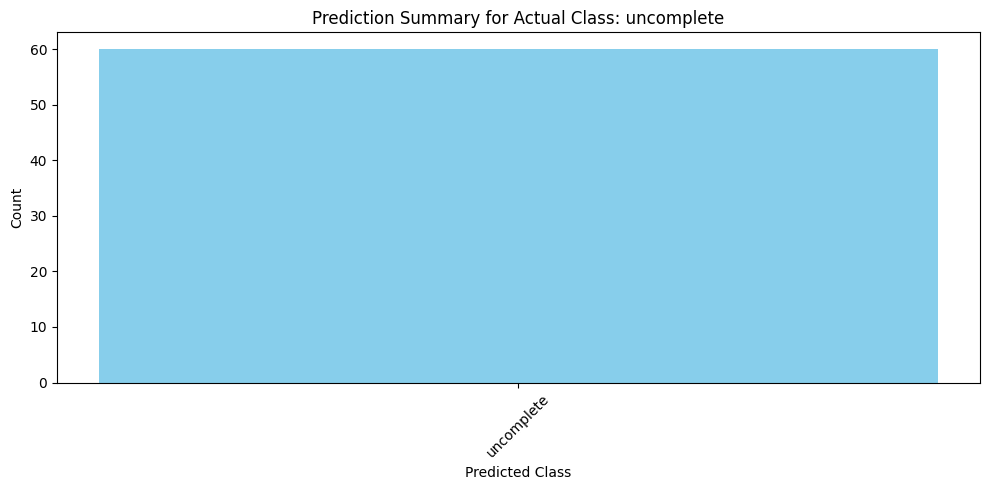

In [ ]:
#Creating a graph
for true_class, predictions in prediction_summary.items():
    labels = []
    values = []

    for predicted_class, count in predictions.items():
        if predicted_class != 'total':
            labels.append(predicted_class)
            values.append(count)

    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color='skyblue')
    plt.xlabel('Predicted Class')
    plt.ylabel('Count')
    plt.title(f'Prediction Summary for Actual Class: {true_class}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Confusion Matrix

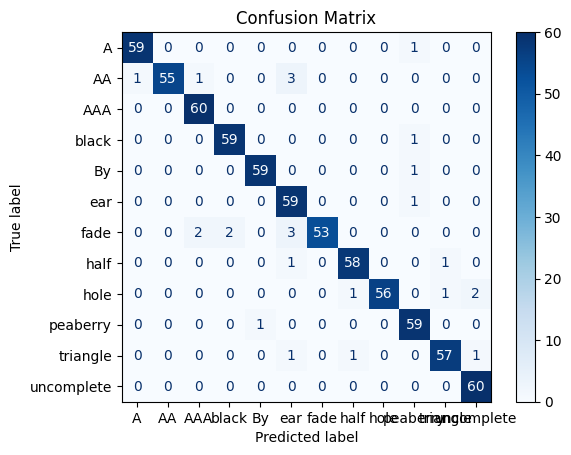

In [ ]:
#Create confusion matrix
class_names = list(prediction_summary.keys())  # List of classes name
cm = confusion_matrix(true_labels, pred_labels, labels=class_names)

#Show confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Calculate Accuracy, F1 score, Precision, Recall

In [ ]:
# Calculate metrics
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))

accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.98      0.98        60
          AA       1.00      0.92      0.96        60
         AAA       0.95      1.00      0.98        60
       black       0.98      0.98      0.98        60
          By       0.97      0.98      0.98        60
         ear       0.88      0.98      0.93        60
        fade       1.00      0.88      0.94        60
        half       0.97      0.97      0.97        60
        hole       1.00      0.93      0.97        60
    peaberry       0.94      0.98      0.96        60
    triangle       0.97      0.95      0.96        60
  uncomplete       0.95      1.00      0.98        60

    accuracy                           0.96       720
   macro avg       0.97      0.96      0.96       720
weighted avg       0.97      0.96      0.96       720

Accuracy: 0.9639
F1 Score: 0.9639
Precision: 0.9657
Recall: 0.9639
